## **Описание проекта:**

Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.

## **Задача проекта:**

Разработать демонстрационную версию поиска изображений по запросу. Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.

## **Описание данных:**

1. Датасеты:
- **train_dataset.csv** - информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний;
- **test_queries.csv** - информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний;
- **ExpertAnnotations.tsv** - данные по соответствию изображения и описания, полученные в результате опроса экспертов;
- **CrowdAnnotations.tsv** - данные по соответствию изображения и описания, полученные с помощью краудсорсинга.

2. Папки с изображениями:
- **train_images** - изображения для тренировки модели;
- **test_images** - изображения для тестирования модели.

## **Юридические ограничения:**

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

## **Содержание:**

[1. Общий обзор данных](#chapter1)

[2. Исследовательский анализ данных](#chapter2)

[3. Проверка данных](#chapter3)

[4. Векторизация изображения](#chapter4)

[5. Векторизация текстов](#chapter5)

[6. Объединение векторов](#chapter6)

[7. Обучение моделей предсказания соответствия](#chapter7)

[8. Тестирование модели](#chapter8)

[9. Итоговые выводы](#chapter9)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import pickle
import tensorflow as tf
import keras_nlp
import sentence_transformers
import glob
import os
import warnings
from nltk.corpus import stopwords
from pathlib import Path
from PIL import Image
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from tqdm import notebook
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from collections import Counter
from keras.applications.resnet import preprocess_input
from sentence_transformers import SentenceTransformer, util
from IPython.display import display
from IPython.display import Image as IPImage

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)


In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
PATH = '/content/to_upload'
RANDOM_STATE = 12345
BLOCK_WORDS = ['teenage',
         'baby',
         'child',
         'teenager',
         'girl',
         'boy',
         'baby',
         'boy',
         'boys',
         'girls',
         'girl',
         'kid',
         'kids',
         'youngster',
         'youth',
         'young',
         'babe',
         ]

In [ ]:
df_train = pd.read_csv(os.path.join(PATH, 'train_dataset.csv'))
df_expert = pd.read_csv(os.path.join(PATH, 'ExpertAnnotations.tsv'),
                          sep='\t',
                          names = ['image', 'query_id', 'first_exp', 'second_exp', 'third_exp'])
df_crowd  = pd.read_csv(os.path.join(PATH, 'CrowdAnnotations.tsv'),
                          sep='\t',
                          names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
df_queries  = pd.read_csv(os.path.join(PATH, 'test_queries.csv'),sep='|', index_col=0)
df_images  = pd.read_csv(os.path.join(PATH, 'test_images.csv'))

**Вывод: Необходимые импорты сделаны, константы сформированы, датасеты загружены. Можно приступать к общему ознакомлению с данными**

<a class="anchor" id="chapter1"></a>

## **1. Общий обзор данных**

In [ ]:
def main_info(df):
    display(df.sample(7))
    print('\n')
    display(df.describe().T)
    print('\n')
    i = df.info()
    return i

**Общий обзор df_train (train_dataset.csv):**

Информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний.

In [ ]:
main_info(df_train)

image                     query_id  \
1746  1404832008_68e432665b.jpg   354642192_3b7666a2dd.jpg#2   
3589   241345844_69e1c22464.jpg   241347760_d44c8d3a01.jpg#2   
2700  3221036999_3f7b152d8a.jpg   245895500_a4eb97af02.jpg#2   
3642  3250695024_93e8ab7305.jpg  3323988406_e3c8fce690.jpg#2   
5105   254295381_d98fa049f4.jpg  2901880865_3fd7b66a45.jpg#2   
4478  3350786891_6d39b234e9.jpg  2373234213_4ebe9c4ee5.jpg#2   
3297  2073105823_6dacade004.jpg   138718600_f430ebca17.jpg#2   

                                             query_text  
1746  A person swimming in water nearby rocks and a ...  
3589  A Sooners football player weas the number 28 a...  
2700  Man fly fishing in a small river with steam in...  
3642          An inline skater doing a jump on a ramp .  
5105                       A surfer is jumping a wave .  
4478   One boy jumps over another boy on a trampoline .  
3297  Two girls are sitting on a path by a river wit...

count unique                                                top  \
image       5822   1000                          2083434441_a93bc6306b.jpg   
query_id    5822    977                        2600867924_cd502fc911.jpg#2   
query_text  5822    977  Two dogs , one brown and white and one black a...   

           freq  
image        10  
query_id     34  
query_text   34



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


**Вывод: Датасет содержит 5822 строк и 3 столбца, все данные категориальные. Количество уникальных описаний: 977. Количество уникальных изображений: 1000**

**Общий обзор df_expert (ExpertAnnotations.tsv):**

Данные по соответствию изображения и описания, полученные в результате опроса экспертов.

In [ ]:
main_info(df_expert)

image                     query_id  first_exp  \
1460   246055693_ccb69ac5c6.jpg   460935487_75b2da7854.jpg#2          2   
29    1096395242_fc69f0ae5a.jpg  2577972703_a22c5f2a87.jpg#2          1   
5530   535830521_aa971319fc.jpg   493621130_152bdd4e91.jpg#2          1   
1868  2610447973_89227ff978.jpg   245895500_a4eb97af02.jpg#2          1   
259    136644343_0e2b423829.jpg  3003691049_f4363c2d5c.jpg#2          1   
2874  3058439373_9276a4702a.jpg  3254817653_632e840423.jpg#2          2   
3293  3192069971_83c5a90b4c.jpg  3062173277_bfb5ef4c45.jpg#2          1   

      second_exp  third_exp  
1460           2          3  
29             1          1  
5530           1          1  
1868           1          2  
259            1          1  
2874           2          3  
3293           1          1

count      mean       std  min  25%  50%  75%  max
first_exp   5822.0  1.436620  0.787084  1.0  1.0  1.0  2.0  4.0
second_exp  5822.0  1.624356  0.856222  1.0  1.0  1.0  2.0  4.0
third_exp   5822.0  1.881999  0.904087  1.0  1.0  2.0  2.0  4.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   first_exp   5822 non-null   int64 
 3   second_exp  5822 non-null   int64 
 4   third_exp   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


**Вывод: Датасет содержит 5822 строк и 5 столбцов. Есть категориальные и численные данные.**

**Общий обзор df_crowd (CrowdAnnotations.tsv):**

Данные по соответствию изображения и описания, полученные с помощью краудсорсинга.

In [ ]:
main_info(df_crowd)

image                     query_id  share_pos  \
19896  2891617125_f939f604c7.jpg  2502905671_c6039804ab.jpg#2        0.0   
35339  3494394662_3edfd4a34c.jpg  2774554310_007e980a90.jpg#2        0.0   
31018  3333921867_6cc7d7c73d.jpg  2999730677_0cfa1c146e.jpg#2        0.0   
64      106490881_5a2dd9b7bd.jpg  2443380641_7b38d18f5b.jpg#2        0.0   
23027  3030566410_393c36a6c5.jpg  2663794355_e726ec7e05.jpg#2        0.0   
27573  3217187564_0ffd89dec1.jpg  1897025969_0c41688fa6.jpg#2        0.0   
10959  2414397449_2ac3b78e0d.jpg   757332692_6866ae545c.jpg#2        0.0   

       count_pos  count_neg  
19896          0          3  
35339          0          3  
31018          0          3  
64             0          4  
23027          0          3  
27573          0          3  
10959          0          3

count      mean       std  min  25%  50%  75%  max
share_pos  47830.0  0.068786  0.207532  0.0  0.0  0.0  0.0  1.0
count_pos  47830.0  0.208488  0.628898  0.0  0.0  0.0  0.0  5.0
count_neg  47830.0  2.820155  0.656676  0.0  3.0  3.0  3.0  6.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   count_pos  47830 non-null  int64  
 4   count_neg  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


**Вывод: Датасет содержит 47830 строк и 5 столбцов. Есть категориальные и численные данные**

**Общий обзор df_queries (test_queries.csv):**

Информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний.

In [ ]:
main_info(df_queries)

query_id  \
151  2687672606_275169c35d.jpg#1   
336  3438981089_2ef1a6353c.jpg#1   
53   1991806812_065f747689.jpg#3   
106  2431120202_b24fe2333a.jpg#1   
94   2399219552_bbba0a9a59.jpg#4   
19   1319634306_816f21677f.jpg#4   
4    1177994172_10d143cb8d.jpg#4   

                                            query_text  \
151  A woman wearing jewelry holds a piece of paper...   
336  A man in a black t-shirt is jumping something ...   
53                        Two boxers are in the ring .   
106                           A girl on skis in snow .   
94   The child in the blue shorts dribbled the bask...   
19        The dog is sitting on the side of the hill .   
4    Two young boys are squirting water at each oth...   

                         image  
151  2687672606_275169c35d.jpg  
336  3438981089_2ef1a6353c.jpg  
53   1991806812_065f747689.jpg  
106  2431120202_b24fe2333a.jpg  
94   2399219552_bbba0a9a59.jpg  
19   1319634306_816f21677f.jpg  
4    1177994172_10d143cb8d.jpg

count unique                                                top  \
query_id     500    500                         989851184_9ef368e520.jpg#4   
query_text   500    500  The black dog has a toy in its mouth and a per...   
image        500    100                          1177994172_10d143cb8d.jpg   

           freq  
query_id      1  
query_text    1  
image         5



<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


**Вывод: Датасет содержит 500 строк и 3 столбца. Все данные категориальные.**

**Общий обзор df_images (test_images.csv):**

Содержатся наименования изображений для тренировки модели.

In [ ]:
main_info(df_images)

image
73  2737233999_34d60dc5c3.jpg
90  3386953179_84c2d7922f.jpg
98  2670637584_d96efb8afa.jpg
59  3044745642_1d0784ff29.jpg
96  2399219552_bbba0a9a59.jpg
22   862156271_3eacea90a8.jpg
30  3393035454_2d2370ffd4.jpg

count unique                        top freq
image   100    100  3356748019_2251399314.jpg    1



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


**Вывод: Датасет содержит 100 наименований изображений. Данные категориальные**

**Общий обзор изображений: train_images - для обучения модели и test_images - для тестирования модели**

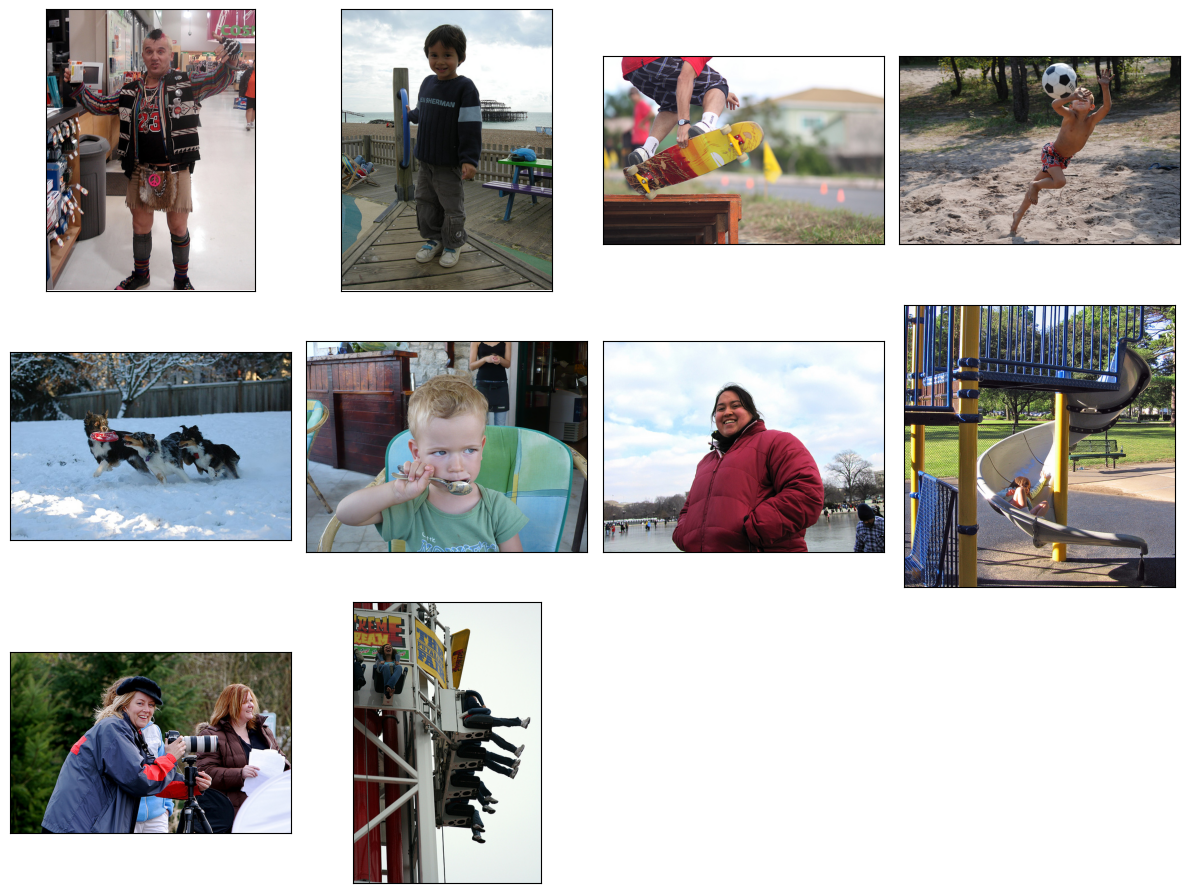

In [ ]:
samples_train = list(df_train['image'].sample(10))

fig = plt.figure(figsize=(12,12))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

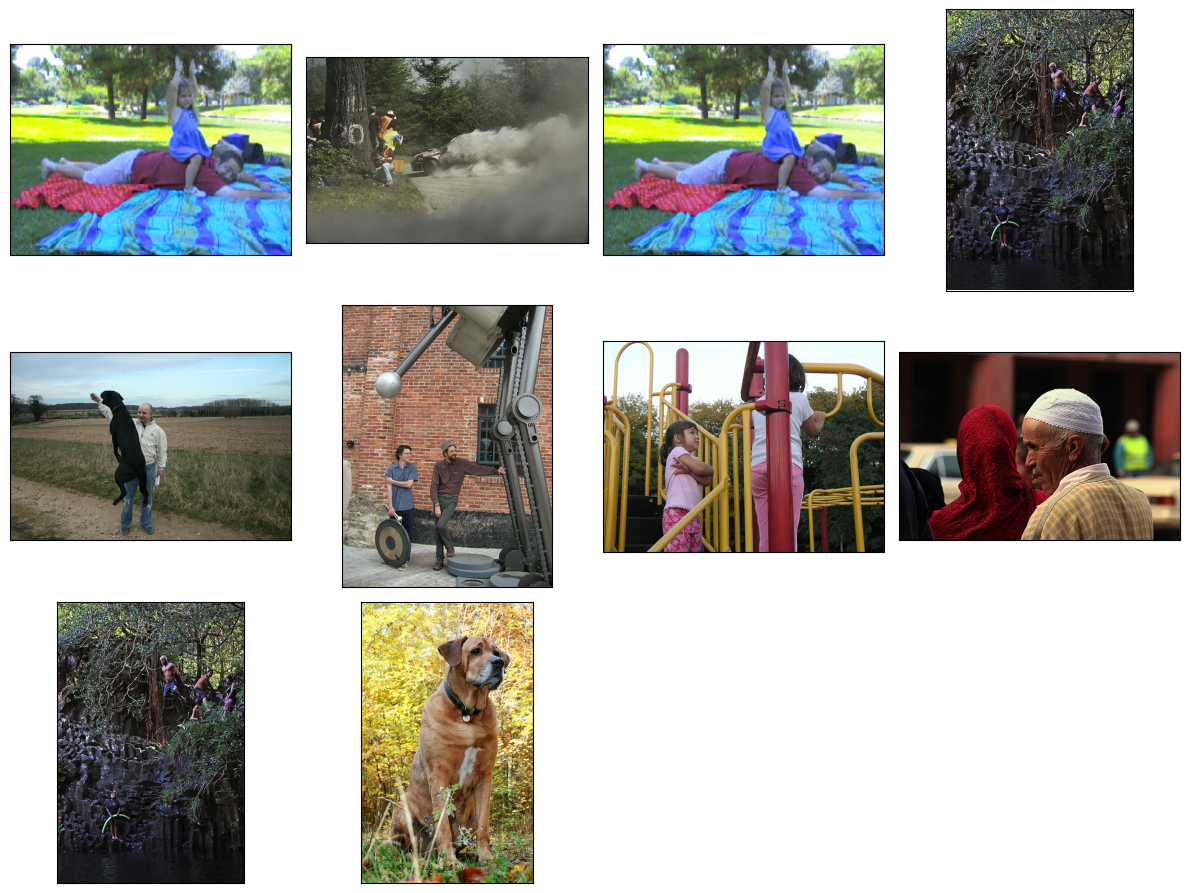

In [ ]:
samples_test = list(df_queries['image'].sample(10))
fig = plt.figure(figsize=(12,12))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод: тренирочные и тестовые папки содержат изображения с  разных категорий: спорт, домашние животные, дикие животные/птицы, дети, путешествия и т.д. В папке с тренировочными данными 100 изображений, с тестовыми 1000**

<a class="anchor" id="chapter2"></a>

## **2. Исследовательский анализ данных**

In [ ]:
# функция для агрегации оценок
def final_score(row) -> object:
    if row['first_exp'] != row['second_exp'] != row['third_exp']:
        row['expert_score'] = (row['first_exp'] + row['second_exp'] + row['third_exp'] - 3) / 3 / 3
    else:
        row['expert_score'] = (max(set([row['first_exp'], row['second_exp'], row['third_exp']]),
                                   key = [row['first_exp'], row['second_exp'], row['third_exp']].count) - 1) / 3
    return row
df_expert = df_expert.apply(final_score, axis=1)

In [ ]:
df_expert.sample(5)

image                     query_id  first_exp  \
1961  2652522323_9218afd8c2.jpg  3472364264_dbde5a8d0a.jpg#2          1   
2950  3085226474_62aba51179.jpg  2662845514_8620aaee96.jpg#2          1   
5284   468608014_09fd20eb9b.jpg  1356796100_b265479721.jpg#2          1   
5585    54501196_a9ac9d66f2.jpg   260828892_7925d27865.jpg#2          1   
3050  3115174046_9e96b9ce47.jpg  3115174046_9e96b9ce47.jpg#2          4   

      second_exp  third_exp  expert_score  
1961           1          1      0.000000  
2950           1          1      0.000000  
5284           1          1      0.000000  
5585           2          2      0.333333  
3050           4          4      1.000000

In [ ]:
# объединяем оценки из датасетов df_expert и df_crowd
df_main_scores = pd.merge(df_expert, df_crowd, how='outer', on=['image', 'query_id'])

def score_aggregate(row) -> object:
    if np.isnan(row['expert_score']):
        row['score'] = row['share_pos']
    elif np.isnan(row['share_pos']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.6 + row['share_pos'] * 0.4
    return row

df_main_scores = df_main_scores.apply(score_aggregate, axis=1)

In [ ]:
main_info(df_main_scores)

image                     query_id  first_exp  \
36287  3437147889_4cf26dd525.jpg  3072114570_e1c0127529.jpg#2        NaN   
20248  2844641033_dab3715a99.jpg  3128164023_ebe8da4c32.jpg#2        NaN   
1591   1311388430_4ab0cd1a1f.jpg  3182121297_38c99b2769.jpg#2        1.0   
973    1237985362_dbafc59280.jpg   170100272_d820db2199.jpg#2        NaN   
47935   506738508_327efdf9c3.jpg  3497224764_6e17544e0d.jpg#2        1.0   
9168   2256133102_e2c8314ecb.jpg  3375991133_87d7c40925.jpg#2        NaN   
15314   256085101_2c2617c5d0.jpg  3498327617_d2e3db3ee3.jpg#2        NaN   

       second_exp  third_exp  expert_score  share_pos  count_pos  count_neg  \
36287         NaN        NaN           NaN        0.0        0.0        3.0   
20248         NaN        NaN           NaN        0.0        0.0        3.0   
1591          2.0        2.0      0.333333        0.0        0.0        3.0   
973           NaN        NaN           NaN        0.0        0.0        3.0   
47935         1.0        2.0      0.000000        0.0        0.0        3.0   
9168          NaN        NaN           NaN        0.0        0.0        3.0   
15314         NaN        NaN           NaN        0.0        0.0        3.0   

       score  
36287    0.0  
20248    0.0  
1591     0.2  
973      0.0  
47935    0.0  
9168     0.0  
15314    0.0

count      mean       std  min  25%  50%       75%  max
first_exp      5822.0  1.436620  0.787084  1.0  1.0  1.0  2.000000  4.0
second_exp     5822.0  1.624356  0.856222  1.0  1.0  1.0  2.000000  4.0
third_exp      5822.0  1.881999  0.904087  1.0  1.0  2.0  2.000000  4.0
expert_score   5822.0  0.208157  0.285431  0.0  0.0  0.0  0.333333  1.0
share_pos     47830.0  0.068786  0.207532  0.0  0.0  0.0  0.000000  1.0
count_pos     47830.0  0.208488  0.628898  0.0  0.0  0.0  0.000000  5.0
count_neg     47830.0  2.820155  0.656676  0.0  3.0  3.0  3.000000  6.0
score         51323.0  0.075049  0.207266  0.0  0.0  0.0  0.000000  1.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         51323 non-null  object 
 1   query_id      51323 non-null  object 
 2   first_exp     5822 non-null   float64
 3   second_exp    5822 non-null   float64
 4   third_exp     5822 non-null   float64
 5   expert_score  5822 non-null   float64
 6   share_pos     47830 non-null  float64
 7   count_pos     47830 non-null  float64
 8   count_neg     47830 non-null  float64
 9   score         51323 non-null  float64
dtypes: float64(8), object(2)
memory usage: 3.9+ MB


In [ ]:
df_train = pd.merge(df_train, df_main_scores[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])

In [ ]:
to_fill = df_train[df_train['query_text'].notna()]

In [ ]:
def fill_text(row) -> object:
    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]
    return row
df_train = df_train.apply(fill_text, axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [ ]:
df_train.dropna(inplace=True)

**Вывод: После добавления текстов, для части query_id нет описаний, удалили такие записи. Провели агрегацию оценок: если оценки разные, то взяли среднюю; если одинаковые, то объединили в единую оценку. Также заполнили пропуски, удалили незаполненные пропуски. Получили датафрейм "признаки-целевой признак", с которым можем продолжать работать**

<a class="anchor" id="chapter3"></a>

## **3.Проверка данных**

In [ ]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text) -> list:
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    text = nltk.word_tokenize(text, language = 'english')
    text = [lemmatize.lemmatize(word) for word in text]
    return text

def cleaning(row) -> object:
    text = get_lemmas(row['query_text'])
    if [i for i in text if i in BLOCK_WORDS]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0
    return row

df_train = df_train.apply(cleaning, axis=1)

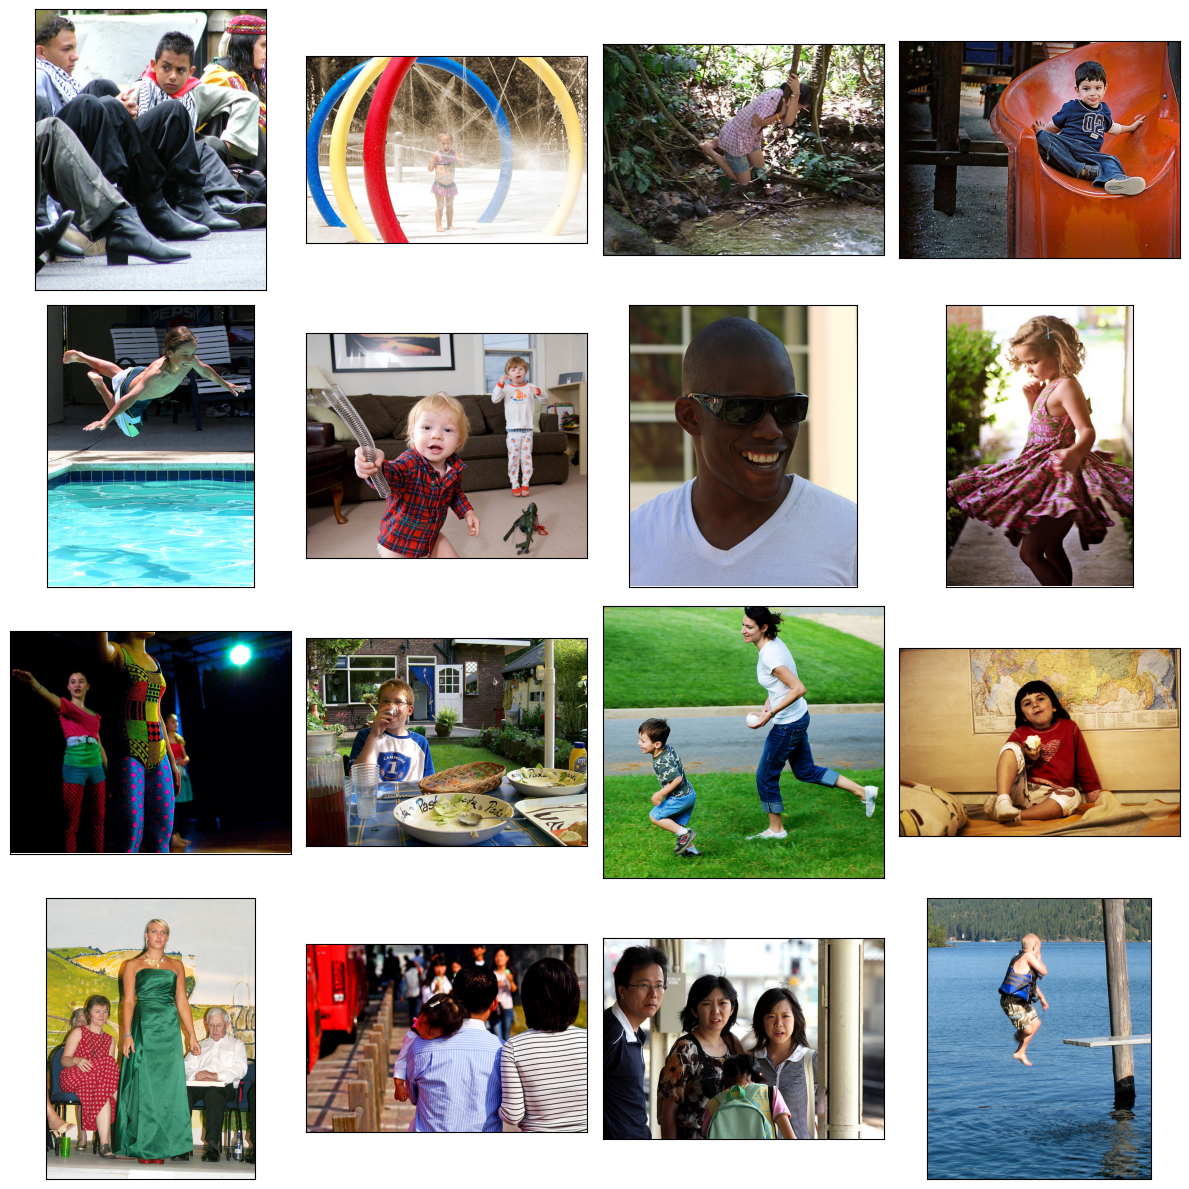

In [ ]:
samples = list(df_train[df_train['to_block'] == 1]['query_id'].sample(20))
samples = [i[:-2] for i in samples]

fig = plt.figure(figsize=(12,12))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [ ]:
block_images = set(list(df_train[df_train['to_block'] == 1]['query_id'].apply(lambda x: x[:-2].lower()).unique()))
print('Всего запрещенных изображений:',len(block_images))

Всего запрещенных изображений: 300


In [ ]:
df_train.drop(df_train.query('image in @block_images').index, inplace=True, errors='ignore')
df_train.drop(columns='to_block', inplace=True, errors='ignore')
df_train.reset_index(inplace=True, drop=True)

**Вывод: Применили фунцкию для очищения текста: удалили неалфавитные символы и привели текст к нижнему регистру; токенизировали и лемматизировали текст. Для проверки взяли 20 рандомных изображениях, которые попали под блокировку. Визуально сложно оценить возраст некоторых людей т.к могут выглядеть старше своих лет. Также провели проверку данных на содержание запрещенных слов, очистили данные**

<a class="anchor" id="chapter4"></a>

## **4.Векторизация изображения**

In [ ]:
def load_img(path=PATH, train=True) -> ImageDataGenerator:

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train if train else df_images,
        directory=Path(path, 'train_images') if train else Path(path, 'test_images'),
        x_col='image',
        y_col='score' if train else None,
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        shuffle=False,
        seed=RANDOM_STATE)

    return train_gen_flow

In [ ]:
def create_model(input_shape=(224, 224, 3)):


    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

In [ ]:
def vectorize_pictures(model, train_data):
    predictions = model.predict(train_data)
    return predictions

In [ ]:
pict_embeds = vectorize_pictures(create_model(), load_img())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Found 35318 validated image filenames.
2208/2208 ━━━━━━━━━━━━━━━━━━━━ 213s 93ms/step


In [ ]:
pict_embeds.shape

(35318, 2048)

**Вывод: Написали функцию, которая  осуществляет трансформацию изображений с помощью сверточной нейронной сети ResNet-50, обученной на наборе данных ImageNet, преобразовали изображения из тренировочного набора данных в векторное представление. Получили эмбеддинги изображений т.е данные изображения ввиде чисел.**

<a class="anchor" id="chapter5"></a>

##**5.Векторизация текстов**

In [ ]:
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

100%|██████████| 510/510 [00:00<00:00, 1.12MB/s]


100%|██████████| 414M/414M [00:28<00:00, 15.3MB/s]


In [ ]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0) -> np.array:
    embeddings = []
    tokenized = preprocessor(data)
    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):
            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}
            batch_embeddings = model.predict(batch, verbose=verbose)
            embeddings.append(batch_embeddings['pooled_output'])
    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size + 1):
            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types,
                    'padding_mask' : mask}
            batch_embeddings = model.predict(batch, verbose=verbose)
            embeddings.append(batch_embeddings['pooled_output'])
    return np.concatenate(embeddings)

text = list(df_train['query_text'])

In [ ]:
text_embeds = vectorize_text(model=bert, data=text)

  0%|          | 0/1104 [00:00<?, ?it/s]

**Вывод: Для получения эмбеддингов из текстов использовали модель BERT**

<a class="anchor" id="chapter6"></a>

##**6.Объединение векторов**

In [ ]:
X = np.concatenate((pict_embeds, text_embeds), axis=1)
X.shape

(35318, 2816)

In [ ]:
y = np.array(df_train['score'])
y.shape

(35318,)

In [ ]:
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

**Вывод: Объединили векторы изображений и векторы текстов с целевой переменной. Теперь можно обучать модели.**

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=df_train['image']))

In [ ]:
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def make_score(model):
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

**Вывод: Разделили датасет на тренировочную и тестовую выборки в пропорции 7:3 , для исключения попадания изображения и в обучающую, и в тестовую выборки воспользовались GroupShuffleSplit. В задачах регрессии для оценки качества модели воспользуемся метрикой MSE, чтобы видеть на какое значение в среднем предсказание отличается от истинного значения.**

<a class="anchor" id="chapter7"></a>

## **7. Обучение моделей предсказания соответствий**

## **Модель №1: Dummy Regressor (базовая модель)**

In [ ]:
model_1 = DummyRegressor(strategy='mean')
model_1.fit(X_train, y_train)
preds_model_1 = model_1.predict(X_test)
score_model_1 = round(make_score(model_1), 3)
print(score_model_1)

0.046


## **Модель №2: Linear Regression (модель линейной регрессии)**

In [ ]:
model_2 = LinearRegression(n_jobs=-1)
model_2.fit(X_train, y_train)
preds_model_2 = model_2.predict(X_test)
score_model_2 = round(make_score(model_2), 3)
print(score_model_2)

0.045


## **Модель №3: LGBM Regressor (модель градиентного бустинга)**

In [ ]:
model_3 = LGBMRegressor(random_state=RANDOM_STATE,
                        n_jobs=-1,
                        num_leaves=2,
                        learning_rate=0.1,
                        max_depth=2,
                        n_estimators=2)
model_3.fit(X_train, y_train)
preds_model_3 = model_3.predict(X_test)
score_model_3 = round(make_score(model_3), 3)
print(score_model_3)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.521484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 709959
[LightGBM] [Info] Number of data points in the train set: 24696, number of used features: 2816
[LightGBM] [Info] Start training from score 0.086200
0.046


## **Модель №4: Нейронная сеть**

In [ ]:
nn = Sequential()
nn.add(Dense(2816, input_shape=(2816,), activation='tanh'))
nn.add(BatchNormalization())
nn.add(Dense(128, activation='tanh'))
nn.add(Dropout(0.3))
nn.add(Dense(64, activation='tanh'))
nn.add(Dropout(0.3))
nn.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=1e-5)
nn.compile(optimizer=optimizer, loss=['mse'],
            metrics=[tf.keras.metrics.MeanSquaredError()])
nn.build()
nn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2816)           │     7,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2816)           │        11,264 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       360,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,312,833 (31.71 MB)

 Trainable params: 8,307,201 (31.69 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [ ]:
nn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=50, epochs=500,
    verbose=2, shuffle=False
    )

Epoch 1/500
494/494 - 9s - 18ms/step - loss: 0.1866 - mean_squared_error: 0.1866 - val_loss: 0.1599 - val_mean_squared_error: 0.1599
Epoch 2/500
494/494 - 6s - 11ms/step - loss: 0.1141 - mean_squared_error: 0.1141 - val_loss: 0.1229 - val_mean_squared_error: 0.1229
Epoch 3/500
494/494 - 2s - 5ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - val_loss: 0.1027 - val_mean_squared_error: 0.1027
Epoch 4/500
494/494 - 2s - 5ms/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0916 - val_mean_squared_error: 0.0916
Epoch 5/500
494/494 - 2s - 5ms/step - loss: 0.0620 - mean_squared_error: 0.0620 - val_loss: 0.0802 - val_mean_squared_error: 0.0802
Epoch 6/500
494/494 - 3s - 7ms/step - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 0.0764 - val_mean_squared_error: 0.0764
Epoch 7/500
494/494 - 2s - 5ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - val_loss: 0.0727 - val_mean_squared_error: 0.0727
Epoch 8/500
494/494 - 3s - 5ms/step - loss: 0.0488 - mean_squared_error: 0

In [ ]:
score_nn_4 = round(make_score(nn), 3)
print(score_nn_4 )

332/332 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
0.045


In [ ]:
results = {'МОДЕЛЬ':['Dummy Regressor',
                   'Linear Regression',
                   'LGBM Regressor',
                   'Нейронная сеть'],
          'МЕТРИКА MSE':[score_model_1,
                   score_model_2,
                   score_model_3,
                   score_nn_4
                       ]
          }
final_results = pd.DataFrame(results)
display(final_results.sort_values(by='МЕТРИКА MSE'))

МОДЕЛЬ  МЕТРИКА MSE
1  Linear Regression        0.045
3     Нейронная сеть        0.045
0    Dummy Regressor        0.046
2     LGBM Regressor        0.046

**Вывод: Обучили разные модели: Dummy Regressor, Linear Regression, LGBM Regressor и 1 нейросеть на 500 эпохах, за основу оценки качества предсказаний взяли метрику MSE. Результаты получились не очень впечатляющие, но не критичные. По итогам обучения лучшая метрика MSE=0,045 у нейронной сети и модели линейной регрессии. Для дальнейшего тестирования будем использовать  полученные пресказания от нейросети.**

<a class="anchor" id="chapter8"></a>

##**8.Тестирование модели**

In [ ]:
picture_test = vectorize_pictures(create_model(), load_img(train=False))
picture_test.shape

Found 100 validated image filenames.
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 900ms/step


(100, 2048)

In [ ]:
def get_picture(text) -> None:
    if [i for i in get_lemmas(text) if i in BLOCK_WORDS]:
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        print('Это изображение недоступно в вашей стране в соответствии с местным законодательством')
        print('')
    else:
        text_embed = vectorize_text(model=bert, data=[text], bar=False)
        X = np.concatenate((
            picture_test,
            np.resize(text_embed, (picture_test.shape[0],768))),
            axis=1)
        X = scaler.transform(X)
        predictions = nn.predict(X)
        df = pd.concat((df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1)
        top = list(df.sort_values(by='pred', ascending=False)['image'].head(5))
        top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(5))

        print('')
        print('-' * 20, text, '-' * 20)
        print('')

        fig = plt.figure(figsize=(15,5))
        plt.rcParams['axes.edgecolor'] = 'black'
        plt.rcParams['axes.linewidth'] = 0
        for i in range(5):
            fig.add_subplot(1, 6, i+1, title=round(top_score[i], 2))
            image = Image.open(Path(PATH, 'test_images', top[i]))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()

        if text in list(df_queries['query_text']):
            plt.rcParams['axes.edgecolor'] = 'green'
            plt.rcParams['axes.linewidth'] = 5
            fig.add_subplot(1, 6, 6)
            image = Image.open(Path(PATH, 'test_images', df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image']))
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        plt.show()

    return None

In [ ]:
samples = df_queries.sample(10)
text_test = list(samples['query_text'])
text_test

['A young boy poses for a picture in front of a playground .',
 'A woman is throwing a bucket of water over a baby in the paddling pool .',
 'A red high speed racing boat skips across the water .',
 'A biker is racing to keep up with the runners',
 'a group of teenagers standing outside of a convienance store .',
 'Little kid in blue coat and hat riding a tricycle .',
 'A group of people in anime cosplay costumes .',
 'A man is doing a jump on a wakeboard in the water .',
 'two young girls wearing pink outfits playing on yellow monkey bars .',
 'A boy flying a red and white kite .']


-------------------- A young boy poses for a picture in front of a playground . --------------------

Это изображение недоступно в вашей стране в соответствии с местным законодательством


-------------------- A woman is throwing a bucket of water over a baby in the paddling pool . --------------------

Это изображение недоступно в вашей стране в соответствии с местным законодательством

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

-------------------- A red high speed racing boat skips across the water . --------------------



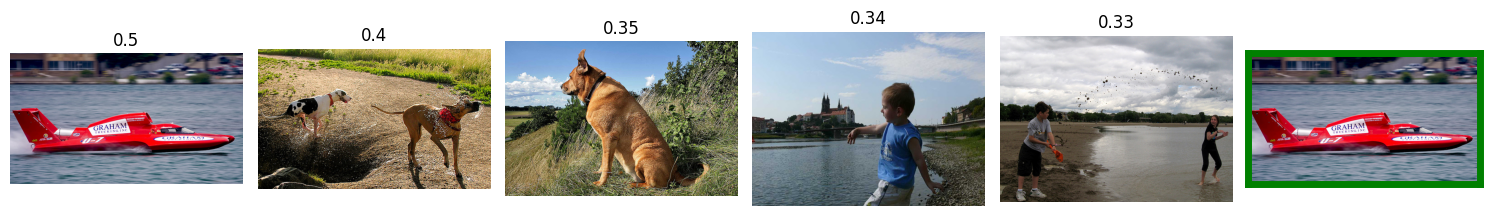

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

-------------------- A biker is racing to keep up with the runners --------------------



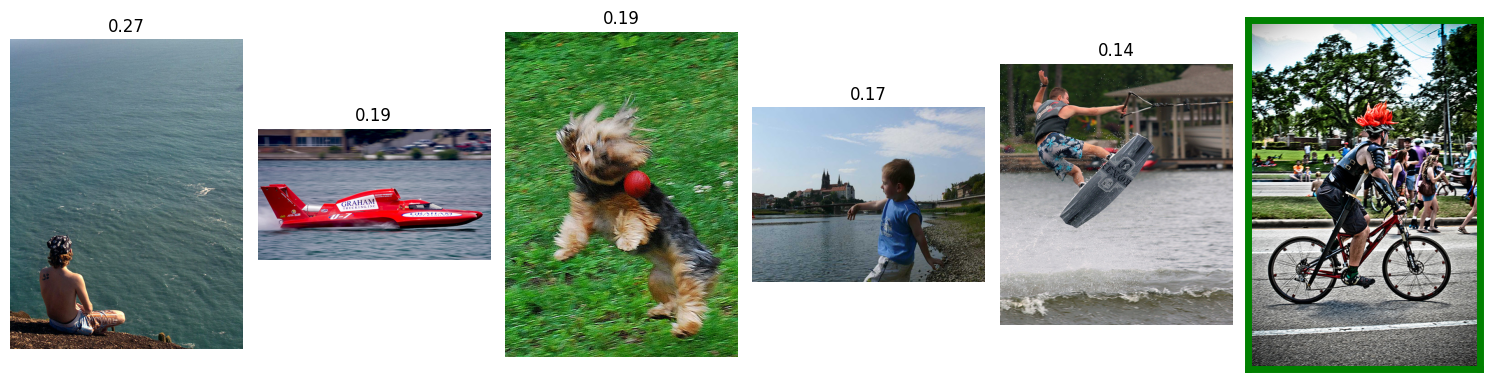


-------------------- a group of teenagers standing outside of a convienance store . --------------------

Это изображение недоступно в вашей стране в соответствии с местным законодательством


-------------------- Little kid in blue coat and hat riding a tricycle . --------------------

Это изображение недоступно в вашей стране в соответствии с местным законодательством

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

-------------------- A group of people in anime cosplay costumes . --------------------



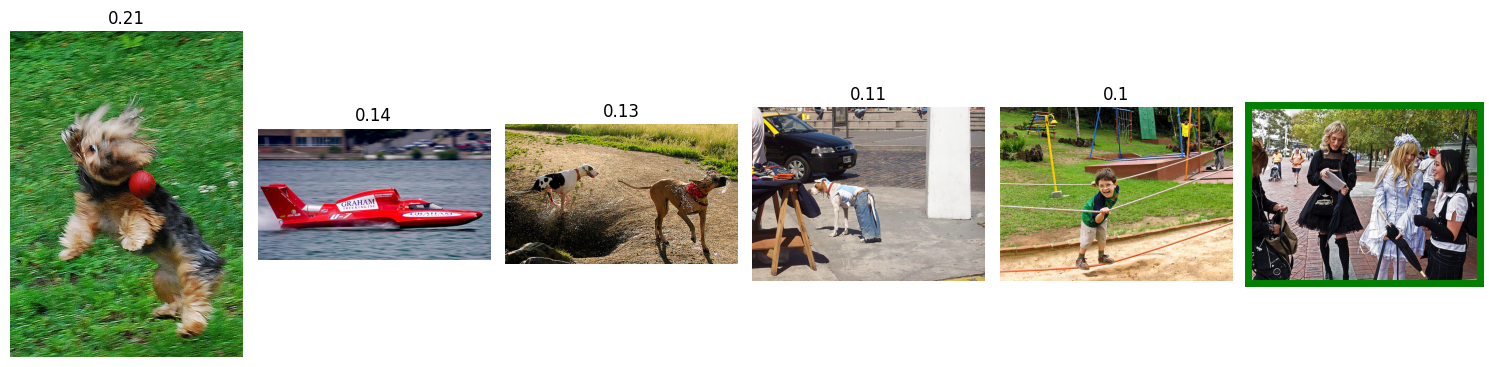

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

-------------------- A man is doing a jump on a wakeboard in the water . --------------------



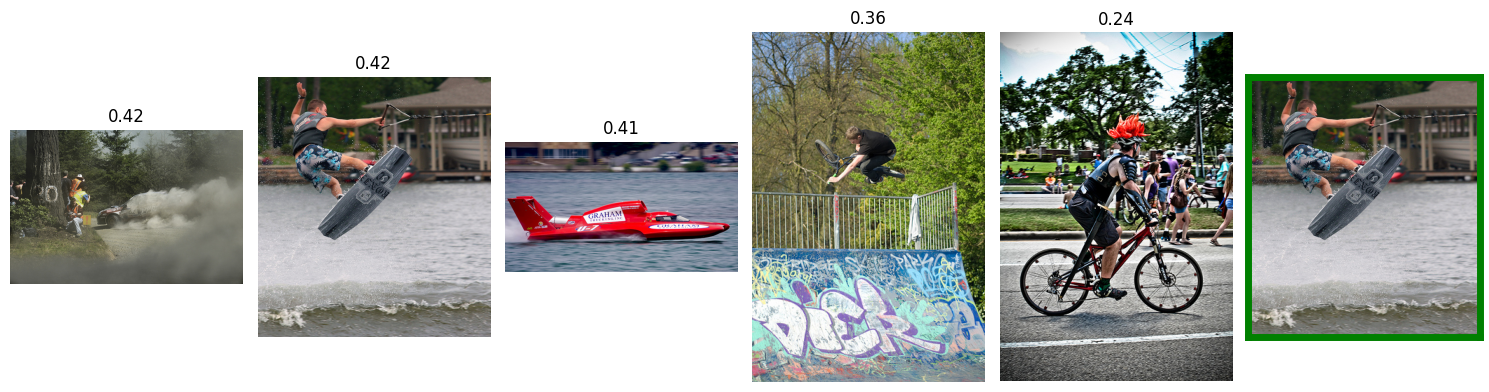


-------------------- two young girls wearing pink outfits playing on yellow monkey bars . --------------------

Это изображение недоступно в вашей стране в соответствии с местным законодательством


-------------------- A boy flying a red and white kite . --------------------

Это изображение недоступно в вашей стране в соответствии с местным законодательством



In [ ]:
for text in text_test:
    get_picture(text)

**Вывод: Если оценивать визуально, то функция на основе предсказаний нейронной сети с задачами проекта справляется, принимает на вход текст и находит соответствующии изображения, также учитывается вывод на экран запрещенных изображений**

<a class="anchor" id="chapter9"></a>

## **9. Итоговые выводы**

**Для выполнения проекта были предоставлены датасеты с разметками изображений по названию, описанию, оценкам соответствия описания и картинки, а также две папки с подготовленными изображениями для тренировочной и тестовой выборки.**

**Исследовательский анализ данных:**
- Провели агрегацию оценок: если оценки разные, то применили среднюю оценку; если одинаковые, то объединили в единую оценку. Также заполнили пропуски, удалили незаполненные пропуски. Получили рабочий датафрейм "признаки"-"целевой признак".

**Проверка данных:**
- Применили фунцкию для очищения текста: удалили неалфавитные символы и привели текст к нижнему регистру; токенизировали и лемматизировали текст.Также провели проверку данных на содержание запрещенных слов, очистили данные.

**Векторизация изображения:**
- Подгрузили сверточную нейронную сеть ResNet-50, обученную на наборе данных ImageNet;
- Написали функцию, которая трансформирует изображения с использованием сверточной нейронной сети ResNet-50;
- Преобразовали изображения из тренировочного набора данных в векторное представление. Получили эмбеддинги изображений т.е данные изображения в виде чисел.

**Векторизация текстов:**
- Подгрузили трансформер BERT;
- Написали функцию, которая трансформирует тексты с использованием трансформера BERT;
- Получили эмбеддинги текстов.

**Объединение векторов:**
- Объединили векторы изображений и векторы текстов с целевой переменной.

**Обучение моделей предсказания соответствий:**
- Разделили датасет на тренировочную (70%) и тестовую (30%) выборки  для исключения попадания изображения и в обучающую, и в тестовую выборки воспользовались GroupShuffleSplit;
- Для оценки качества модели приняли метрику MSE, чтобы видеть на какое значение в среднем предсказание отличается от истинного значения;
- Обучили модели: Dummy Regressor, Linear Regression, LGBM Regressor и 1 нейросеть на 500 эпохах, По итогам обучения лучшая метрика MSE=0,045 у нейронной сети и модели линейной регрессии.

**Тестирование модели:**
- Для тестирования использовали модель нейронной сети;
- Оценивая визуально, можно сказать, что функция на основе предсказаний нейронной сети с задачами проекта справляется, принимает на вход текст и находит соответствующии изображения, также учитывается вывод на экран запрещенных изображений.

**Рекомендации по улучшению качества предсказаний:**
- Можно использовать бОльшее кол-во эпох для обучения нейросети т.к метрика на валидации стабильно улучшалась на протяжении 500 эпох. Возможно стоит пересмотреть архетектуру нейросети, попробовать другие функции активации, подобрать порог оптимизатора;
- Положительную роль может сыграть увеличение предоставленных изображений и данных для тренировки и тестирования.